In [15]:
import numpy as np 
import pandas as pd 
import cv2
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle

from keras.models import load_model

import os
print(os.listdir('data'))


['test_images', 'traffic-signs-classification-with-cnn', 'traffic-signs-dataset-in-yolo-format', 'traffic-signs-preprocessed', 'trainedtrafficsignsdetectorbasedonyolov3']


In [16]:
labels = pd.read_csv('data/traffic-signs-preprocessed/label_names.csv')

print(labels.head())
print()

print(labels.iloc[0][1])  # Speed limit (20km/h)
print(labels['SignName'][0]) # Speed limit (30km/h)


   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

Speed limit (20km/h)
Speed limit (20km/h)


In [17]:
model = load_model('data/traffic-signs-classification-with-cnn/model-3x3.h5')
with open('data/traffic-signs-preprocessed/mean_image_rgb.pickle', 'rb') as f:
    mean = pickle.load(f, encoding='latin1')  
    
print(mean['mean_image_rgb'].shape) 


(3, 32, 32)


In [18]:
path_to_weights = 'data/trainedtrafficsignsdetectorbasedonyolov3/yolov3_ts_train_5000.weights'
path_to_cfg = 'data/traffic-signs-dataset-in-yolo-format/yolov3_ts_test.cfg'

network = cv2.dnn.readNetFromDarknet(path_to_cfg, path_to_weights)


## Getting names of YOLO v3 output layers

In [19]:
layers_all = network.getLayerNames()
layers_names_output = [layers_all[i - 1] for i in network.getUnconnectedOutLayers()]

print()
print(layers_names_output) 



['yolo_82', 'yolo_94', 'yolo_106']


In [20]:
probability_minimum = 0.2
threshold = 0.2
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

print(type(colours))
print(colours.shape)
print(colours[0])


<class 'numpy.ndarray'>
(43, 3)
[228  25  69]


In [21]:
video = cv2.VideoCapture('data/traffic-signs-dataset-in-yolo-format/traffic-sign-to-test.mp4')
OUTPUT_VIDEO_NAME = 'result_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'avc1')

writer = None
h, w = None, None


In [22]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (3, 3)

f = 0
t = 0

while True:
    ret, frame = video.read()

    if not ret:
        break
       
    if w is None or h is None:
        h, w = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    network.setInput(blob)
    start = time.time()
    output_from_network = network.forward(layers_names_output)
    end = time.time()

    f += 1
    t += end - start

    print('Frame number {0} took {1:.5f} seconds'.format(f, end - start))

    bounding_boxes = []
    confidences = []
    class_numbers = []

    for result in output_from_network:
        for detected_objects in result:
            scores = detected_objects[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > probability_minimum:
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
                

    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    if len(results) > 0:
        for i in results.flatten():
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            c_ts = frame[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
            
            if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
                pass
            else:
                blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
                blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
                blob_ts = blob_ts.transpose(0, 2, 3, 1)

                scores = model.predict(blob_ts)

                prediction = np.argmax(scores)

                colour_box_current = colours[class_numbers[i]].tolist()

                cv2.rectangle(frame, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 2)

                text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
                                                       confidences[i])

                cv2.putText(frame, text_box_current, (x_min, y_min - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 2)

    if writer is None:
        writer = cv2.VideoWriter(OUTPUT_VIDEO_NAME, fourcc, 25,
                                 (frame.shape[1], frame.shape[0]), True)

    writer.write(frame)

video.release()
writer.release()


Frame number 1 took 0.43835 seconds
1/1 [==============================] - 0s 13ms/step
Frame number 2 took 0.19098 seconds
1/1 [==============================] - 0s 14ms/step
Frame number 3 took 0.18330 seconds
1/1 [==============================] - 0s 13ms/step
Frame number 4 took 0.18165 seconds
1/1 [==============================] - 0s 13ms/step
Frame number 5 took 0.18196 seconds
1/1 [==============================] - 0s 12ms/step
Frame number 6 took 0.18230 seconds
1/1 [==============================] - 0s 12ms/step
Frame number 7 took 0.18222 seconds
1/1 [==============================] - 0s 14ms/step
Frame number 8 took 0.17896 seconds
1/1 [==============================] - 0s 15ms/step
Frame number 9 took 0.17686 seconds
1/1 [==============================] - 0s 15ms/step
Frame number 10 took 0.18163 seconds
1/1 [==============================] - 0s 14ms/step
Frame number 11 took 0.18150 seconds
1/1 [==============================] - 0s 12ms/step
Frame number 12 took 0.18166 s

In [23]:
print('Total number of frames', f)
print('Total amount of time {:.5f} seconds'.format(t))
print('FPS:', round((f / t), 1))


Total number of frames 56
Total amount of time 10.39403 seconds
FPS: 5.4


In [32]:
image_BGR = cv2.imread('data/test_images/traffic-signs-in-a-residential-area-KPTWG4.jpg')
OUTPUT_IMAGE_NAME = 'result_image.png'
print('Image shape:', image_BGR.shape) 

h, w = image_BGR.shape[:2] 

print('Image height={0} and width={1}'.format(h, w)) 

Image shape: (960, 1300, 3)
Image height=960 and width=1300


In [33]:
t = 0

blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416), swapRB=True, crop=False)

network.setInput(blob)
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

t += end - start
print('Total amount of time {:.5f} seconds'.format(t))

bounding_boxes = []
confidences = []
class_numbers = []

for result in output_from_network:
    for detected_objects in result:
        scores = detected_objects[5:]
        class_current = np.argmax(scores)
        confidence_current = scores[class_current]

        if confidence_current > probability_minimum:
            box_current = detected_objects[0:4] * np.array([w, h, w, h])

            x_center, y_center, box_width, box_height = box_current
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)
                
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

if len(results) > 0:
    for i in results.flatten():
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
        c_ts = image_BGR[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
            
        if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
            pass
        else:
            blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
            blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
            blob_ts = blob_ts.transpose(0, 2, 3, 1)
            scores = model.predict(blob_ts)

            prediction = np.argmax(scores)
            print(labels['SignName'][prediction])

            colour_box_current = colours[class_numbers[i]].tolist()

            cv2.rectangle(image_BGR, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 2)

            text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
                                                   confidences[i])

            cv2.putText(image_BGR, text_box_current, (x_min, y_min - 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, [2, 2, 2], 2)
 
# Saving image
cv2.imwrite(OUTPUT_IMAGE_NAME, image_BGR)


Total amount of time 0.18772 seconds
1/1 [==============================] - 0s 12ms/step
Go straight or left
1/1 [==============================] - 0s 13ms/step
No entry
1/1 [==============================] - 0s 12ms/step
Road work


True

Image shape: (960, 1300, 3)
Image height=960 and width=1300


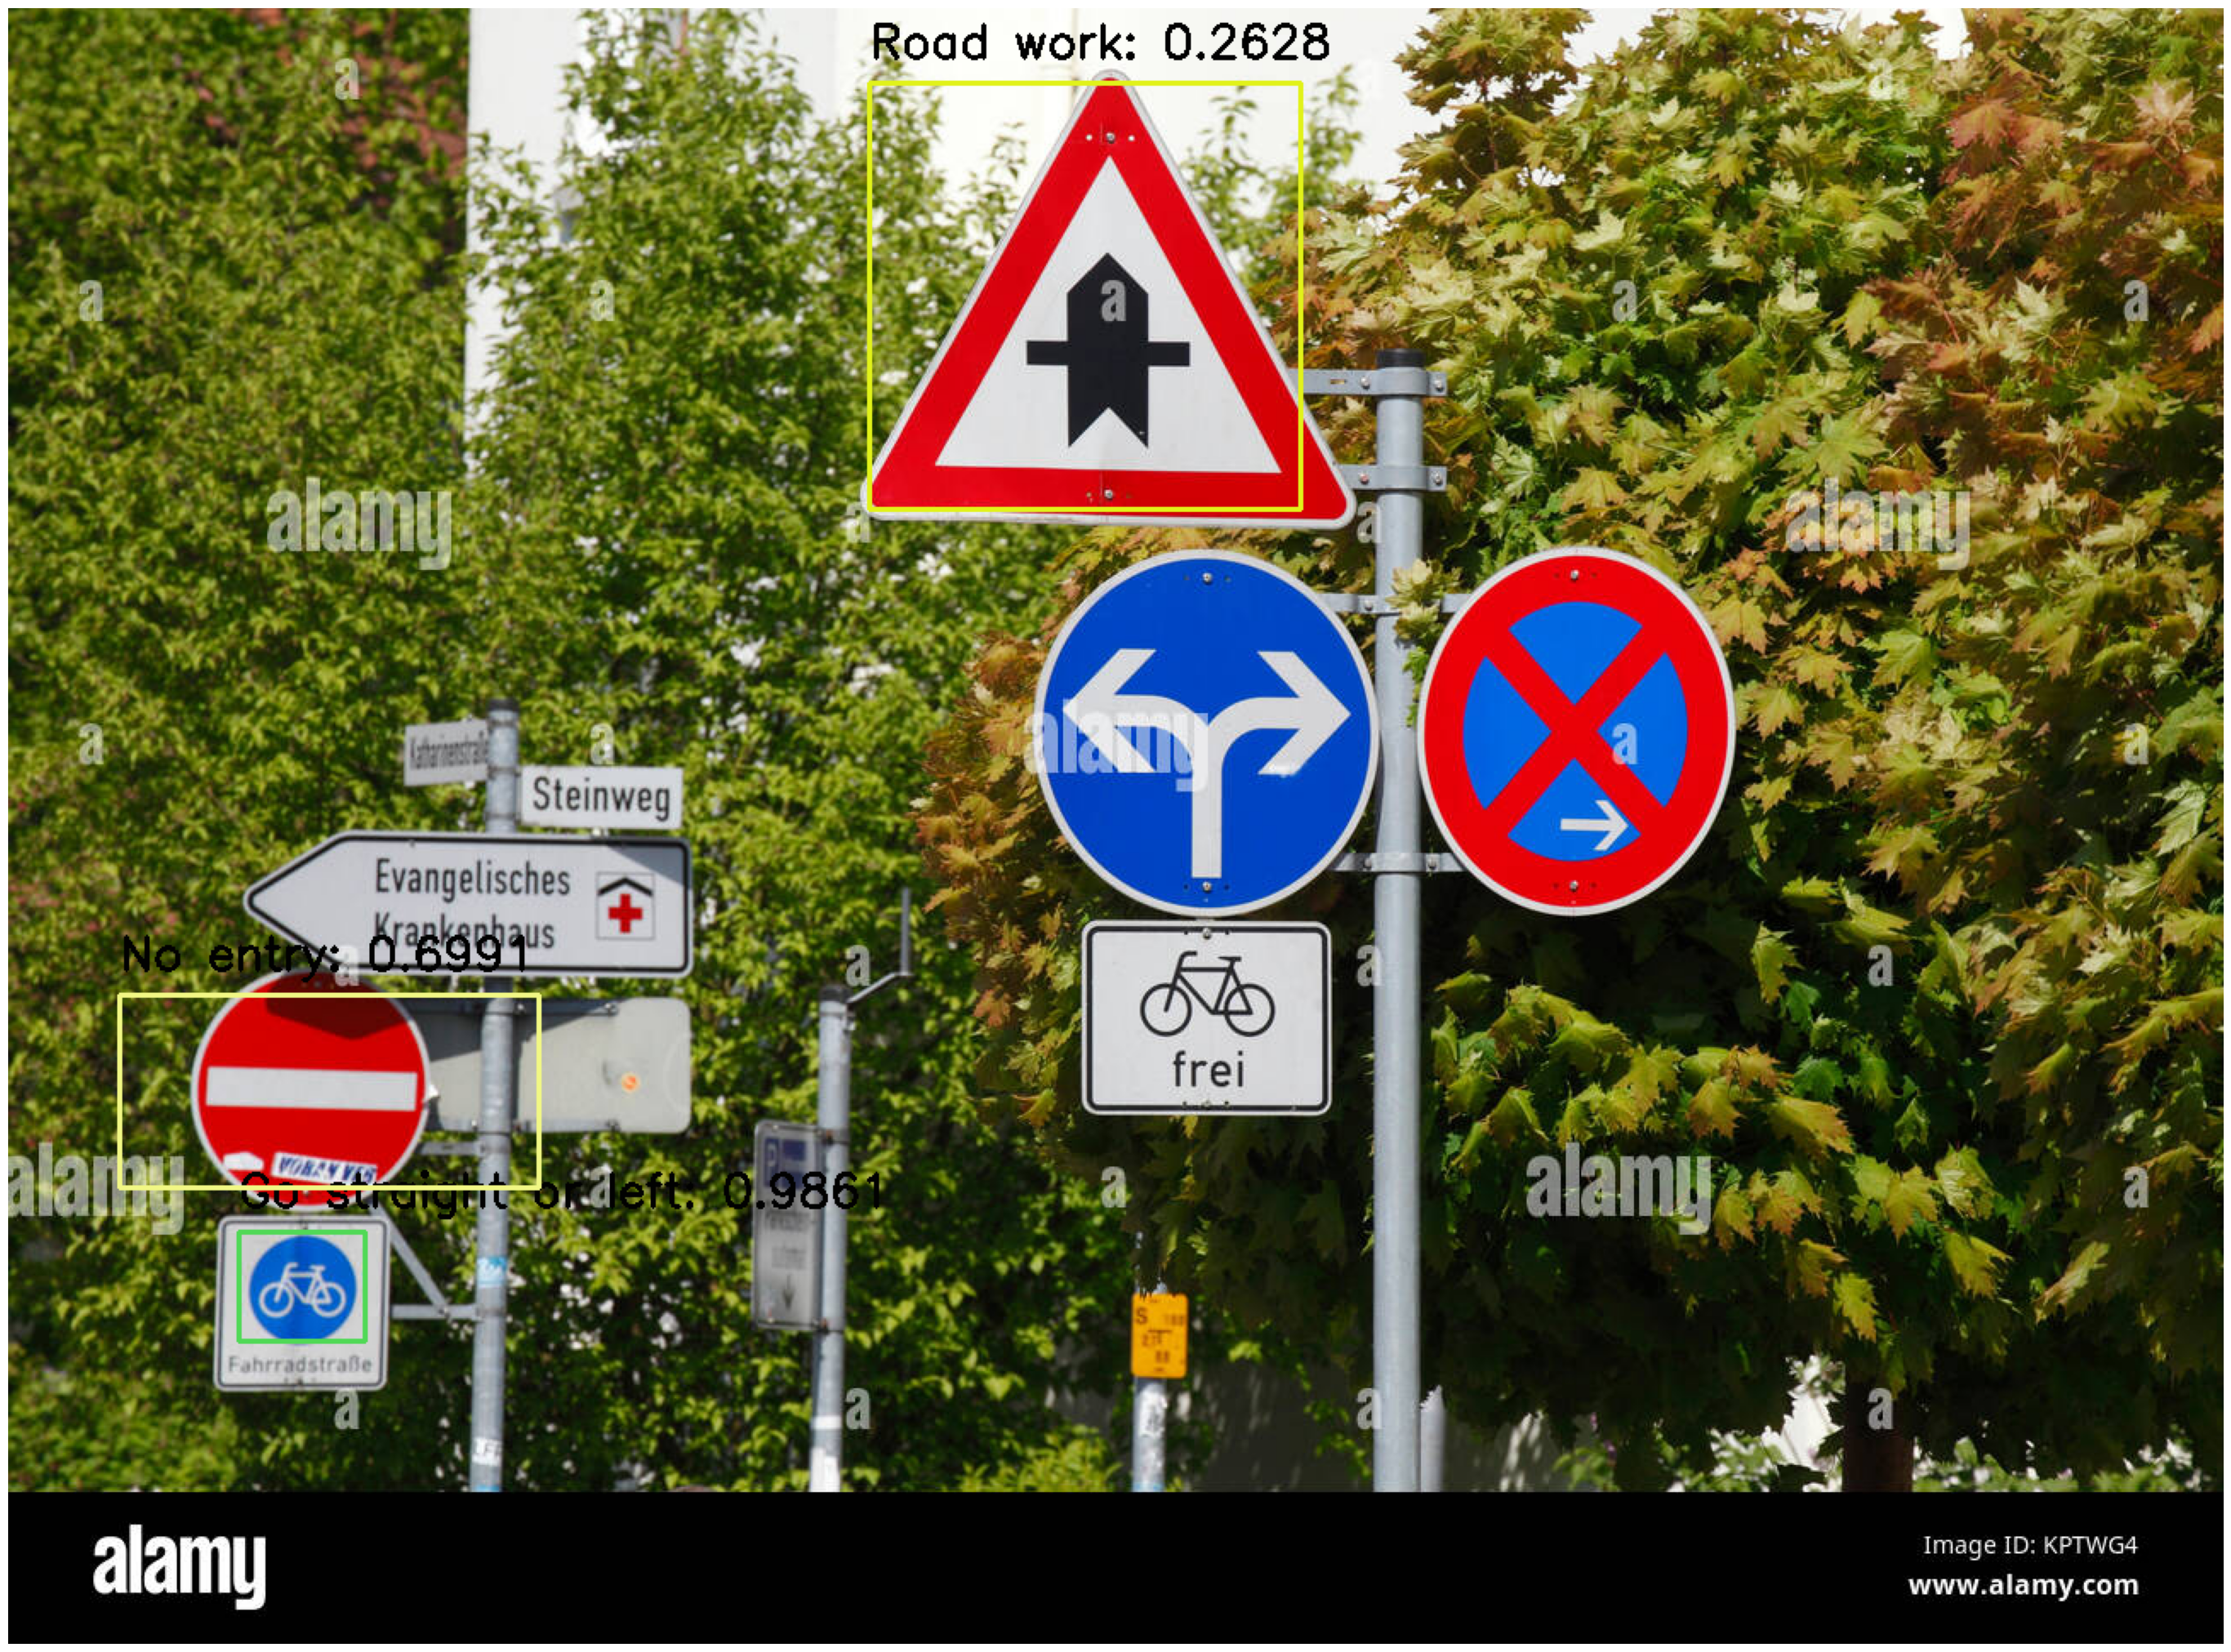

In [34]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (35.0, 35.0) 
image_BGR = cv2.imread(OUTPUT_IMAGE_NAME)

print('Image shape:', image_BGR.shape) 

h, w = image_BGR.shape[:2]

# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w))

plt.imshow(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()
plt.close()
